In [5]:
# Instalasi dan impor dependensi
!pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

In [13]:
# Membuat sesi Spark
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [17]:
# Baca dataset
data = spark.read.csv("dataset.csv", header=True, inferSchema=True)

# Konversi kolom "view" menjadi tipe data numerik
data = data.withColumn("view", data["view"].cast(DoubleType()))

# Membersihkan data dengan mengabaikan baris yang memiliki nilai-nilai yang tidak valid
data = data.dropna(subset=["category_id", "view"])

# Preprocessing data
indexer = StringIndexer(inputCol="category_id", outputCol="category_index")
data = indexer.fit(data).transform(data)

assembler = VectorAssembler(inputCols=["category_index"], outputCol="features")
data = assembler.transform(data)

# Split dataset menjadi training set dan test set
(training, test) = data.randomSplit([0.8, 0.2])

# Membangun model Random Forest Regressor
rf = RandomForestRegressor(labelCol="view", featuresCol="features")
model = rf.fit(training)

# Memprediksi jumlah view menggunakan model
predictions = model.transform(test)

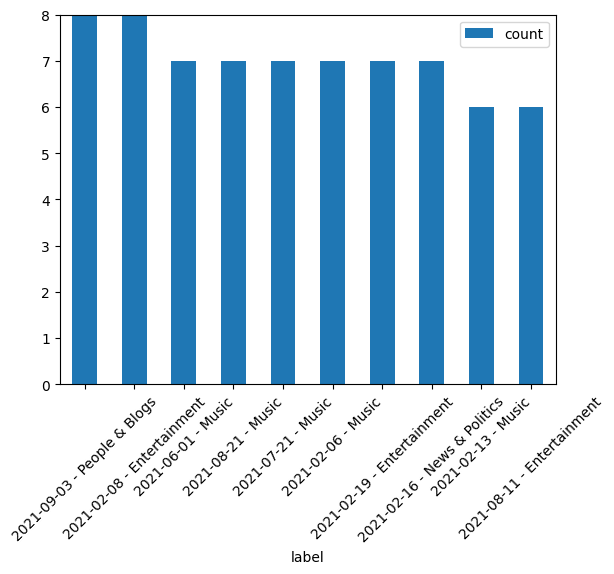

In [23]:
# Mengatur font yang mendukung karakter CJK
plt.rcParams["font.family"] = "DejaVu Sans"

# Mengambil kolom publish_time dan category_id dari dataset
time_category = predictions.select("publish_time", "category_id")

# Menghitung jumlah video berdasarkan waktu dan kategori
video_count = time_category.groupBy("publish_time", "category_id").count()

# Mengubah hasil agregasi menjadi Pandas DataFrame
video_count_df = video_count.toPandas()

# Menggabungkan kolom "publish_time" dan "category_id" menjadi satu kolom "label"
video_count_df["label"] = pd.to_datetime(video_count_df["publish_time"]).dt.strftime("%Y-%m-%d") + " - " + video_count_df["category_id"].replace({
    "1": "Film & Animation",
    "2": "Autos & Vehicles",
    "10": "Music",
    "15": "Pets & Animals",
    "17": "Sports",
    "18": "Short Movies",
    "19": "Travel & Events",
    "20": "Gaming",
    "21": "Videoblogging",
    "22": "People & Blogs",
    "23": "Comedy",
    "24": "Entertainment",
    "25": "News & Politics",
    "26": "Howto & Style",
    "27": "Education",
    "28": "Science & Technology",
    "30": "Movies",
    "31": "Anime/Animation",
    "32": "Action/Adventure",
    "33": "Classics",
    "34": "Comedy",
    "35": "Documentary",
    "36": "Drama",
    "37": "Family",
    "38": "Foreign",
    "39": "Horror",
    "40": "Sci-Fi/Fantasy",
    "41": "Thriller",
    "42": "Shorts",
    "43": "Shows",
    "44": "Trailers"
})

# Mengurutkan berdasarkan count secara menurun
video_count_df = video_count_df.sort_values(by="count", ascending=False)

# Mengambil 10 bar teratas
top_10_video_count_df = video_count_df.head(10)

# Menampilkan grafik batang
top_10_video_count_df.plot(kind="bar", x="label", y="count")
plt.xticks(rotation=45)
plt.ylim(0, video_count_df["count"].max())
plt.show()

In [ ]:
# Pada grafik batang, sumbu y menunjukkan skala count atau jumlah video.
# Skala 0-8 pada grafik mungkin terjadi karena ada beberapa kategori atau waktu
# tertentu di mana jumlah video yang ada relatif sedikit, sehingga rentang nilai
# pada sumbu y menjadi terbatas pada kisaran tersebut. Hal ini dapat terjadi jika
# terdapat data yang tidak seimbang, di mana beberapa kategori atau waktu memiliki
# jumlah video yang jauh lebih sedikit dibandingkan dengan yang lain.